<a href="https://colab.research.google.com/github/daniel7634/ml_test/blob/master/decision_tree_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Classifier

參考自 [Machine Learning Recipes with Josh Gordon](https://youtu.be/LDRbO9a6XPU)。

實作 CART (Classification and Regression Tree)，

計算 Gini Impurity 跟 Information Gain 來建立 tree，

主要將程式碼改成使用 torch.tensor 實作。


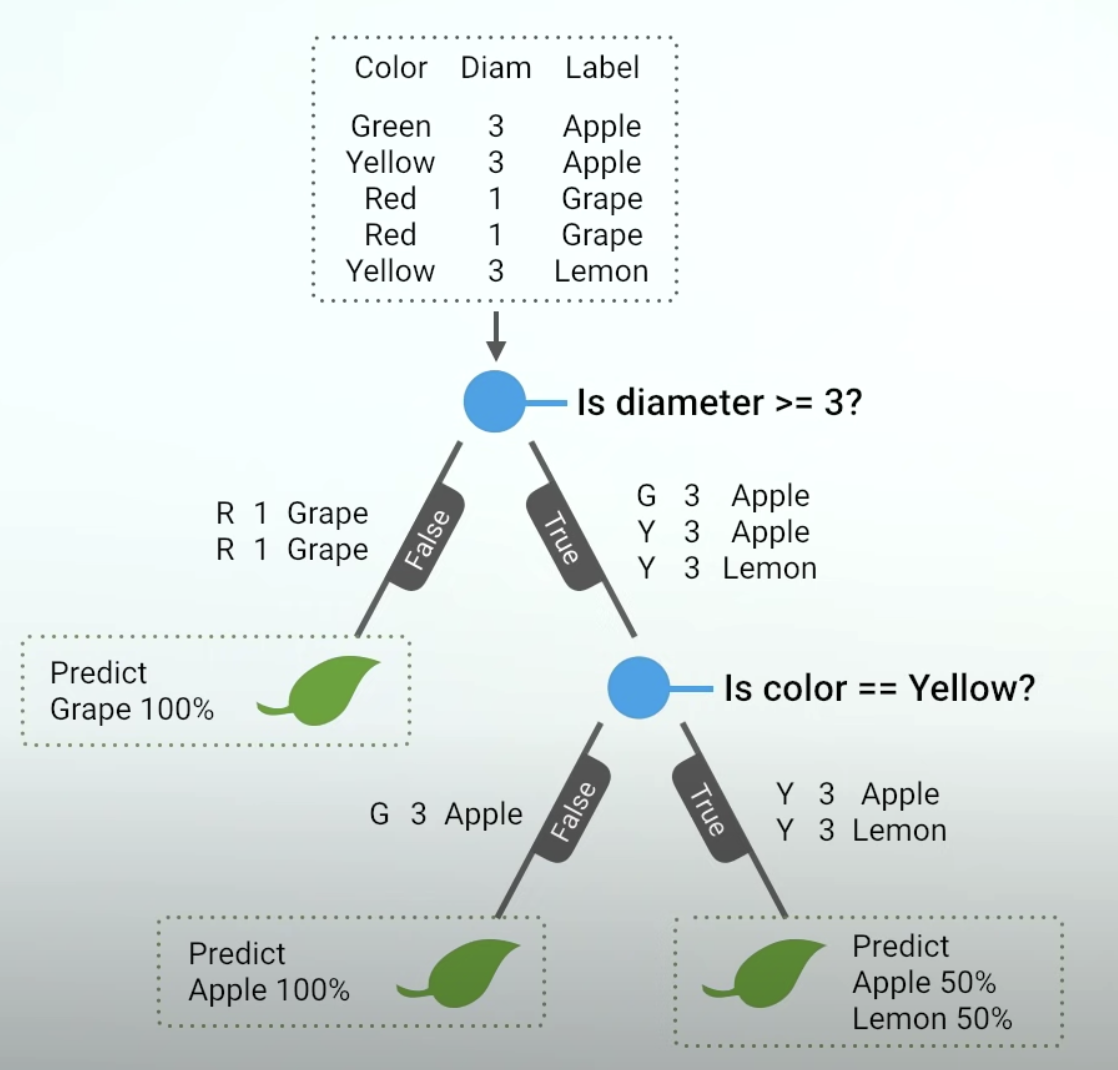

In [1]:
from enum import Enum

import torch


class Color(Enum):
    GREEN = 0
    YELLOW = 1
    RED = 2

class Fruit(Enum):
    APPLE = 0
    GRAPE = 1
    LEMON = 2

header = ['color', 'diameter', 'label']
training_data = torch.tensor([
    [Color.GREEN.value, 3, Fruit.APPLE.value],
    [Color.YELLOW.value, 3, Fruit.APPLE.value],
    [Color.RED.value, 1, Fruit.GRAPE.value],
    [Color.RED.value, 1, Fruit.GRAPE.value],
    [Color.YELLOW.value, 3, Fruit.LEMON.value],
])
training_data.to('cuda')

tensor([[0, 3, 0],
        [1, 3, 0],
        [2, 1, 1],
        [2, 1, 1],
        [1, 3, 2]], device='cuda:0')

In [2]:
from torch import Tensor

"""Find the unique values for a column in a dataset."""
def unique_vals(data: Tensor, col):
    return torch.unique(data[:, col])

"""Demo"""
print(unique_vals(training_data, 0), unique_vals(training_data, 1))

tensor([0, 1, 2]) tensor([1, 3])


In [3]:
def class_counts(data):
    labels, count = torch.unique(data[:, -1], return_counts=True)
    return dict(zip(labels, count))

"""Demo"""
class_counts(training_data)

{tensor(0): tensor(2), tensor(1): tensor(2), tensor(2): tensor(1)}

In [4]:
col_2_enum = {
    0: Color,
    2: Fruit,
}

def get_col_enum_class(col):
    return col_2_enum.get(col)

"""Demo"""
print(get_col_enum_class(0), get_col_enum_class(1))

<enum 'Color'> None


In [5]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        enum_class = get_col_enum_class(self.column)
        if enum_class:
            return val == self.value
        else:
            return val >= self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        enum_class = get_col_enum_class(self.column)
        if enum_class:
            condition = '=='
            value_str = next(name for name, member in Color.__members__.items() if member.value == self.value)
        else:
            condition = '>='
            value_str = str(self.value)

        return f'Is {header[self.column]} {condition} {value_str}?'

In [6]:
"""Demo for a numeric question"""
q1 = Question(1, 3)
q1

Is diameter >= 3?

In [7]:
"""Demo for a categorical attribute"""
q2 = Question(0, Color.GREEN.value)
q2 

Is color == GREEN?

In [8]:
"""Demo for the match method"""
# Let's pick an example from the training set...
example = training_data[0]

print("Example = %s" % example, "%s %s" % (q1, q1.match(example)), "%s %s" % (q2, q2.match(example)), sep = '\n')

Example = tensor([0, 3, 0])
Is diameter >= 3? tensor(True)
Is color == GREEN? tensor(True)


In [9]:
def partition(rows: Tensor, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    
    return torch.stack(true_rows, dim=0) if true_rows else None, torch.stack(false_rows, dim=0) if false_rows else None

In [10]:
"""Demo for function partition"""
# Let's partition the training data based on whether rows are Red.
true_rows, false_rows = partition(training_data, Question(0, Color.RED.value))

# The "true rows" will contain all the samples with the feature 'red',
# while the false rows, will contain all the other ones.
print(f'True rows: {true_rows}', f'False rows: {false_rows}', sep = '\n')

True rows: tensor([[2, 1, 1],
        [2, 1, 1]])
False rows: tensor([[0, 3, 0],
        [1, 3, 0],
        [1, 3, 2]])


# 計算 Gini Impurity
\begin{align}
    Gini &= 1-\sum\limits_{i = 0}^k{p_i^2}
\end{align}

In [11]:
def gini(rows: Tensor) -> Tensor:
    """Calculate the Gini Impurity for a list of rows.
    """
    _, count = torch.unique(rows[:, -1], return_counts=True)
    impurity = 1 - torch.sum(torch.pow(count/len(rows), 2))
    return impurity

In [12]:
"""Demo for gini function with no mixing"""

no_mixing = torch.tensor(
    [
        [Fruit.APPLE.value],
        [Fruit.APPLE.value]
    ]
)
# this will return 0
gini(no_mixing)  # 0.0

tensor(0.)

In [13]:
"""Demo for the gini function with mixing"""

# Now, we'll look at dataset with a 50:50 apples:oranges ratio
some_mixing = torch.tensor(
    [
        [Fruit.APPLE.value],
        [Fruit.GRAPE.value]
    ]
)
# this will return 0.5 - meaning, there's a 50% chance of misclassifying
# a random example we draw from the dataset.
gini(some_mixing)

tensor(0.5000)

In [14]:
"""Demo for gini function with mixing"""
# Now, we'll look at a dataset with many different labels
lots_of_mixing = torch.tensor(
    [[0],
    [1],
    [2],
    [3],
    [4]]
)
# This will return 0.8
gini(lots_of_mixing)

tensor(0.8000)

# 計算 Information Gain

In [15]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [16]:
"""Demo for gini function with mixing"""

# Calculate the uncertainy of our training data.
current_uncertainty = gini(training_data)
current_uncertainty

tensor(0.6400)

In [17]:
"""Demo for information gain"""

# How much information do we gain by partioning on 'Green' or 'Red'?
true_rows_green, false_rows_green = partition(training_data, Question(0, Color.GREEN.value))
true_rows_red, false_rows_red = partition(training_data, Question(0, Color.RED.value))

info_gain_green = info_gain(true_rows_green, false_rows_green, current_uncertainty)
info_gain_red = info_gain(true_rows_red, false_rows_red, current_uncertainty)

print("Info gain for 'Red': %s\nInfo gain for 'Green': %s" % (info_gain_green, info_gain_red))
print("'True' splits for red: %s\n'False' splits for red: %s" % (true_rows_red, false_rows_red))
print("'True' splits for green: %s\n'False' splits for green: %s" % (true_rows_green, false_rows_green))

Info gain for 'Red': tensor(0.1400)
Info gain for 'Green': tensor(0.3733)
'True' splits for red: tensor([[2, 1, 1],
        [2, 1, 1]])
'False' splits for red: tensor([[0, 3, 0],
        [1, 3, 0],
        [1, 3, 2]])
'True' splits for green: tensor([[0, 3, 0]])
'False' splits for green: tensor([[1, 3, 0],
        [2, 1, 1],
        [2, 1, 1],
        [1, 3, 2]])


In [18]:
def find_best_split(rows: Tensor):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = unique_vals(rows, col)
        # values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if true_rows is None or false_rows is None:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [19]:
"""Demo for the function finding the best question"""
best_gain, best_question = find_best_split(training_data)
best_question

Is diameter >= tensor(3)?

In [20]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [21]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [22]:
def build_tree(rows):
    gain, question = find_best_split(rows)

    if gain == 0:
        return Leaf(rows)

    true_rows, false_rows = partition(rows, question)

    true_branch = build_tree(true_rows)
    false_branch = build_tree(false_rows)

    return Decision_Node(question, true_branch, false_branch)

In [23]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [24]:
my_tree = build_tree(training_data)

In [25]:
print_tree(my_tree)

Is diameter >= tensor(3)?
--> True:
  Is color == YELLOW?
  --> True:
    Predict {tensor(0): tensor(1), tensor(2): tensor(1)}
  --> False:
    Predict {tensor(0): tensor(1)}
--> False:
  Predict {tensor(1): tensor(2)}


In [26]:
def classify(row, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [27]:
"""Demo for classification"""

# The tree predicts the 1st row of our
# training data is an apple with confidence 1.
classify(training_data[0], my_tree)

{tensor(0): tensor(1)}

In [28]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [29]:
"""Demo for printing the predictions at a leaf """

print_leaf(classify(training_data[0], my_tree))

{tensor(0): '100%'}

In [30]:
"""Demo for printing the predictions at a leaf """

# On the second example, the confidence is lower
print_leaf(classify(training_data[1], my_tree))

{tensor(0): '50%', tensor(2): '50%'}

In [31]:
# Evaluate
testing_data = torch.tensor([
    [Color.GREEN.value, 3, Fruit.APPLE.value],
    [Color.YELLOW.value, 4, Fruit.APPLE.value],
    [Color.RED.value, 2, Fruit.GRAPE.value],
    [Color.RED.value, 1, Fruit.GRAPE.value],
    [Color.YELLOW.value, 3, Fruit.LEMON.value],
])
testing_data.to('cuda')

tensor([[0, 3, 0],
        [1, 4, 0],
        [2, 2, 1],
        [2, 1, 1],
        [1, 3, 2]], device='cuda:0')

In [32]:
for row in testing_data:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))

Actual: tensor(0). Predicted: {tensor(0): '100%'}
Actual: tensor(0). Predicted: {tensor(0): '50%', tensor(2): '50%'}
Actual: tensor(1). Predicted: {tensor(1): '100%'}
Actual: tensor(1). Predicted: {tensor(1): '100%'}
Actual: tensor(2). Predicted: {tensor(0): '50%', tensor(2): '50%'}
